In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nanpercentile as pct
%matplotlib inline
from PIL import Image
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceCatalog
from astropy.visualization import simple_norm
from photutils.segmentation import SegmentationImage
from astropy.io import fits
import multicolorfits as mcf
import matplotlib.cm as cm
import pandas as pd
from tqdm.notebook import tqdm, trange
import os

### Load in Convolved+Reprojected Image Arrays & Segmentation Image

In [4]:
filters = 'F200W F300M F335M F360M F770W F1000W F1130W F2100W'.split()
im_dict = {}
dir = '/Users/ryanlessing/Library/CloudStorage/OneDrive-JohnsHopkins/PHANGS/GMC-Photometry/Convolved_Reprojected_to_F2100W/'
for filt in filters:
    fn = dir + filt + '.fits'
    im_dict[filt] = fits.open(fn)[0].data

In [5]:
segmentation_image = fits.open('/Users/ryanlessing/Library/CloudStorage/OneDrive-JohnsHopkins/PHANGS/GMC-Photometry/GMCcat_ngc0628_12m+7m+tp_co21_native_maxgmc.fits')[0]
segmentation_image.header['NAXIS'] = 2
del segmentation_image.header['NAXIS3']
gmc_cat = segmentation_image.data[0,:,:]
gmc = SegmentationImage(gmc_cat)
segment_list = gmc.segments

segment_flux_dict = {}
for filt in filters:
    data = im_dict[filt]
    cat = SourceCatalog(data, gmc)
    labels = np.arange(cat.nlabels)
    cat_subset = cat.get_labels(labels)  # select a subset of objects
    columns = ['label', 'segment_flux']
    tbl = cat_subset.to_table(columns=columns)
    tbl['segment_flux'].info.format = '{:.4f}'
    flux_list = list(tbl['segment_flux'])
    flux_list.pop(0)
    segment_flux_dict[filt] = flux_list

outlines = gmc.outline_segments(mask_background=True)
gmcmap = gmc.make_cmap(seed=1234)

### Segment Outline Function
Adapted from Photutils SegmentationImage.outline_segments

In [6]:
def outline_segment(gmc, i, mask_background=False):
    from scipy.ndimage import (generate_binary_structure, grey_dilation, grey_erosion)

    # mode='constant' ensures outline is included on the array borders
    selem = generate_binary_structure(gmc._ndim, 1)  # edge connectivity
    eroded = grey_erosion(gmc.data, footprint=selem, mode='constant', cval=0.)
    dilated = grey_dilation(gmc.data, footprint=selem, mode='constant', cval=0.)

    outlines = ((dilated != eroded) & (gmc.data != 0)).astype(int)
    outlines *= gmc.data

    if mask_background:
        outlines = np.ma.masked_where(outlines != i, outlines)

    outlines[outlines == i] = 0.8

    return outlines

### Define Cutout Function

In [7]:
def cutout_image(segment_list, i, im_dict, filts, gmc, square_crop, save=False, path=None, scale=None, color=True):
    # image = im_dict[filt].data
    bbox = segment_list[i].bbox
    x = int(bbox.center[1]); y = int(bbox.center[0])
    dx = bbox.shape[1]; dy = bbox.shape[0]

    outlines = outline_segment(gmc, i+1, mask_background=True)

    if len(filts) == 3 and type(filts) != str:
        # filts = [alma.data, im_dict['F2100W'].data, hst_275.data]
        images = [im_dict[filts[0]], im_dict[filts[1]], im_dict[filts[2]]]

        if square_crop == True:
            if dx > dy:
                slice = np.s_[y-dx:y+dx, x-dx:x+dx]
                red_grey, green_grey, blue_grey, outline = rgb_cutout_scaling(images, slice, outlines, scale)

            else:
                slice = np.s_[y-dy:y+dy, x-dy:x+dy]
                red_grey, green_grey, blue_grey, outline = rgb_cutout_scaling(images, slice, outlines, scale)

        elif square_crop == False:
            slice = bbox.get_overlap_slices(images[0].shape[1:3])
            red_grey, green_grey, blue_grey, outline = rgb_cutout_scaling(images, (slice[0][0], slice[0][1]), outlines, scale)

        red = mcf.colorize_image(red_grey,'FF0000', colorintype='hex')
        green = mcf.colorize_image(green_grey, '#00FF00', colorintype='hex')
        blue = mcf.colorize_image(blue_grey, '#0000FF', colorintype='hex')
        im_section = mcf.combine_multicolor([red, green, blue], gamma=2, inverse=False)

        if color == False:
            fig, axs = plt.subplots(1, 4, figsize=(15,15))

            axs[0].set_title('RGB')
            axs[0].imshow(im_section, vmin=pct(im_section, 0), vmax=pct(im_section, 100), origin='lower')
            axs[0].imshow(outline, origin='lower', cmap='Greys')

            axs[1].set_title(filts[0])
            axs[1].imshow(red_grey, vmin=pct(red_grey, 0), vmax=pct(red_grey, 100), cmap=cm.Greys, origin='lower')
            axs[1].imshow(outline, origin='lower', cmap='autumn')

            axs[2].set_title(filts[1])
            axs[2].imshow(green_grey, vmin=pct(green_grey, 0), vmax=pct(green_grey, 100), cmap=cm.Greys, origin='lower')
            axs[2].imshow(outline, origin='lower', cmap='summer')

            axs[3].set_title(filts[2])
            axs[3].imshow(blue_grey, vmin=pct(blue_grey, 0), vmax=pct(blue_grey, 100), cmap=cm.Greys, origin='lower')
            axs[3].imshow(outline, origin='lower', cmap='winter')

            return None

    elif len(filts) == 1 or type(filts) == str:
        if type(filts) == str:
            image = im_dict[filts]
            # print(image.size, image.shape)
        else:
            image = im_dict[filts[0]]
        if square_crop == True:
            if dx > dy:
                slice = np.s_[y-dx:y+dx, x-dx:x+dx]
                im_section = image[slice]
                outline = outlines[slice]

            else:
                slice = np.s_[y-dy:y+dy, x-dy:x+dy]
                im_section = image[slice]
                outline = outlines[slice]

        elif square_crop == False:
            slice = bbox.get_overlap_slices(image.shape)
            im_section = image[slice[0][0], slice[0][1]]
            outline = outlines[slice[0][0], slice[0][1]]

    plt.figure()
    plt.imshow(im_section, vmin=pct(im_section, 0), vmax=pct(im_section, 100), origin='lower')
    plt.imshow(outline, origin='lower', interpolation='nearest', vmin=0, vmax=0, cmap='Greys')

    if save == True:
        plt.savefig(path)

In [8]:
def rgb_cutout_scaling(filts, slice, outlines, scale):
  red = filts[0][slice]; green = filts[1][slice]; blue = filts[2][slice]

  red = mcf.greyRGBize_image(red,rescalefn=scale,scaletype='abs',min_max=[pct(red, 0), pct(red, 100)])
  green = mcf.greyRGBize_image(green,rescalefn=scale,scaletype='abs',min_max=[pct(green, 5),pct(green, 95)])
  blue = mcf.greyRGBize_image(blue,rescalefn=scale,scaletype='abs',min_max=[pct(blue, 5),pct(blue, 95)])
  outline = outlines[slice]

  return red, green, blue, outline

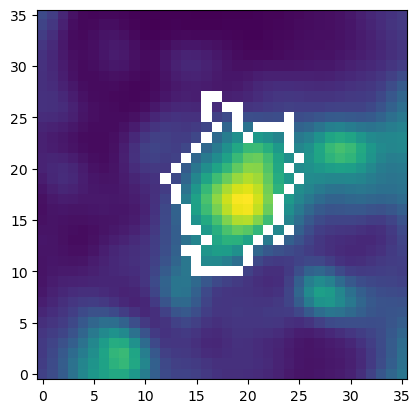

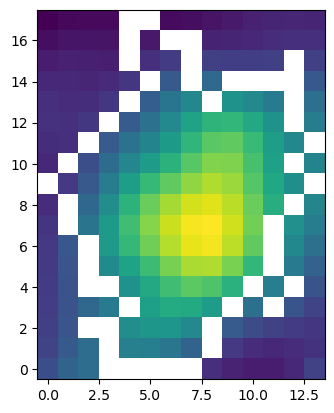

In [9]:
i = 630
cutout_image(segment_list,i,im_dict, 'F770W', gmc, 1)
cutout_image(segment_list,i,im_dict, 'F770W', gmc, 0)

# Multicolor Fits

In [10]:
#mcf.mcf_gui()

dir = '/Users/ryanlessing/Library/CloudStorage/OneDrive-JohnsHopkins/PHANGS/GMC-Photometry/Convolved_Reprojected_to_F2100W/HST+ALMA Regrid Attempt/'
hst_275 = fits.open(dir + 'hst275.fits')[0]
alma = fits.open(dir + 'alma.fits')[0]

hdu275_data = hst_275.data
hdu275_data[hdu275_data == 0] = np.nan

hdu2100_data = im_dict['F2100W']
hdu2100_data[hdu2100_data == 0] = np.nan

alma_data = alma.data
alma_data[alma_data == 0] = np.nan

im_dict['ALMA'] = alma_data
im_dict['HST275'] = hdu275_data

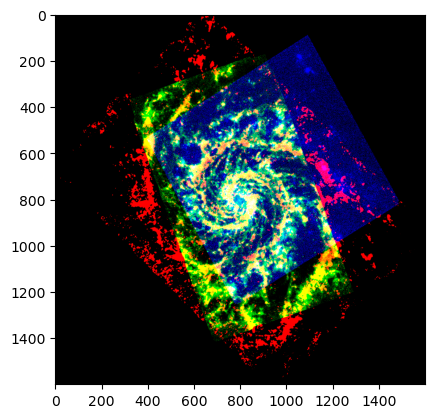

In [11]:
hdu2100_greyRGB=mcf.greyRGBize_image(im_dict['F2100W'].data,rescalefn='asinh',scaletype='abs',min_max=[pct(hdu2100_data, 30), pct(hdu2100_data, 90)]);
hdu275_greyRGB=mcf.greyRGBize_image(hst_275.data,rescalefn='asinh',scaletype='abs',min_max=[pct(hdu275_data, 30),pct(hdu275_data, 90)]);
alma_greyRGB=mcf.greyRGBize_image(alma.data,rescalefn='asinh',scaletype='abs',min_max=[pct(alma_data, 80), pct(alma_data, 85)]);

alma_red = mcf.colorize_image(alma_greyRGB,'FF0000', colorintype='hex')
hdu2100_green=mcf.colorize_image(hdu2100_greyRGB, '#00FF00', colorintype='hex')
hdu275_blue = mcf.colorize_image(hdu275_greyRGB, '#0000FF', colorintype='hex')

image_RGB=mcf.combine_multicolor([alma_red, hdu2100_green, hdu275_blue], gamma=2, inverse=False)

plt.imshow(image_RGB)

In [12]:
path = '/Users/ryanlessing/Library/CloudStorage/OneDrive-JohnsHopkins/PHANGS/GMC-Photometry/NGC628/RGB.fits'
hdr = hst_275.header
mcf.saveRGBfits(path, image_RGB, hdr, overwrite=True)
im_dict['RGB'] = fits.open(path)[0].data

In [13]:
path_wide = '/Users/ryanlessing/Library/CloudStorage/OneDrive-JohnsHopkins/PHANGS/GMC-Photometry/NGC628/Segments_RGB_Wide/'
path_narrow = '/Users/ryanlessing/Library/CloudStorage/OneDrive-JohnsHopkins/PHANGS/GMC-Photometry/NGC628/Segments_RGB_Narrow/'

flux_table = pd.read_csv('/Users/ryanlessing/Library/CloudStorage/OneDrive-JohnsHopkins/PHANGS/GMC-Photometry/NGC628/fluxtable.csv')

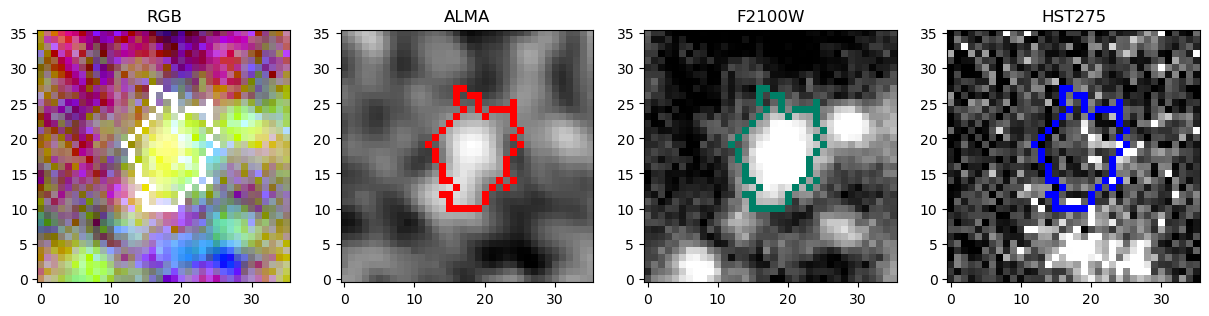

In [14]:
filts = 'ALMA F2100W HST275'.split()
i = 630
cutout_image(segment_list,i,im_dict,filts, gmc, square_crop=1, scale='asinh', color=0)